# Primeiro Experimento

Nesse primeiro experimento vamos realizar a reconstrução 3D de alguns edifícios levando em conta os seguintes critérios:

* Complexidade da cobertura - Igreja da Sé
* Diversidade de platos horizontais - Banespão
* Pojeção com curvaturas - Copan
* Topologias com rings interiores - Faculdade de Direito São Francisco
* Telhados com diversas águas - Colégio Caetano de Campos (República)
* Coberturas com curvatura simples - Biblioteca Latino Americana (Memorial da América Latina)
* Coberturas com dupla curvatura - Oca
* Edifícios com recortes em projeção - Martinelli
* Lotes com múltiplos edifícios separados - Casa Modernista
* Feição simples - Coreto da Luz

## Selecionando os elementos

Em muitos dos casos acima oso lotes coincidem com a edificação, mas em outros casos teremos que definir uma geometria de recorte. Para isso vamos criar uma tabela

## Objetivo inicial

Reconstruir as gemetrias com LOD1.3, e discutir as possibilidades de criação de LOD2.0

## Obtendo os dados

Os polígonos  das áreas de estudo estão em um arquivo contendo os 10 registros

In [1]:
import pdal
import json
import numpy as np

In [2]:
import geopandas as gpd

In [3]:
areas_estudo = gpd.read_file("./gis/locais-selecionados.gpkg", layer='locais-selecionados')

In [4]:
areas_estudo

,Nome,Lote,geometry
0,Casa Modernista,042.029.0021,"POLYGON ((333309.176 7389518.129, 333308.290 7..."
1,Oca,None,"POLYGON ((331023.350 7390484.674, 331023.350 7..."
2,Biblioteca Latino Americana,None,"POLYGON ((329902.822 7397074.728, 330006.485 7..."
3,Colégio Caetano de Campos,None,"POLYGON ((332159.584 7395288.375, 332240.211 7..."
4,Copan,006.064.0000-06,"POLYGON ((332134.639 7395024.162, 332140.343 7..."
5,Martinelli,001.072.0000-01,"POLYGON ((333062.581 7395130.320, 333068.549 7..."
6,Banespão,001.074.0002,"POLYGON ((333246.947 7395112.386, 333249.292 7..."
7,Faculdade de Direito São Francisco,005.013.0007,"POLYGON ((332950.887 7394641.380, 332939.286 7..."
8,Igreja da Sé,005.026.0001,"POLYGON ((333190.216 7394572.960, 333226.077 7..."
9,Coreto da Luz,None,"POLYGON ((333064.671 7396500.426, 333064.671 7..."


In [197]:
s = areas_estudo.iloc[2].geometry

In [198]:
s.wkt

'POLYGON ((329902.8219270367 7397074.727579715, 330006.4848134278 7397065.041905987, 330001.9386054882 7397016.38519398, 329898.2757190971 7397026.070867708, 329902.8219270367 7397074.727579715))'

In [199]:
bounds = ([s.bounds[0], s.bounds[2]], [s.bounds[1], s.bounds[3]])

In [200]:
ept = [
    {
      "type": "readers.ept",
      "filename": "https://ept-m3dc-pmsp.s3-sa-east-1.amazonaws.com/ept.json",
      "bounds": str(bounds)
    },
#     {
#         "type":"filters.voxelcentroidnearestneighbor",
#         "cell":0.5
#     },
    {
        "type":"filters.crop",
        "polygon":s.wkt
    },
    {   
        "type":"filters.hag_delaunay"
#     },
#     {   "type":"filters.eigenvalues",
#         "knn":16
    },
    {   "type":"filters.normal",
        "knn":30
    },
    {
        "type":"filters.dbscan",
        "min_points":12,
        "eps":1.5,
        "dimensions":"X,Y,Z"
    },
#     {
#         "type":"filters.cluster"
#     },
    {
        "type":"writers.las",
        "compression":"laszip",
        "filename":"results/coreto-luz.laz"
    }
]

pipeline = pdal.Pipeline(json.dumps(ept))
pipeline.validate()
%time n_points = pipeline.execute()
print(f'Pipeline selected {n_points} points')

CPU times: user 6.12 s, sys: 63.7 ms, total: 6.18 s
Wall time: 6.7 s
Pipeline selected 73257 points


In [201]:
import pandas as pd
arr = pipeline.arrays[0]
df = pd.DataFrame(arr)
# print(df.head().to_latex(index=False))
df.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,...,Red,Green,Blue,OriginId,HeightAboveGround,NormalX,NormalY,NormalZ,Curvature,ClusterID
0,329936.84,7397062.01,725.18,35,1,1,1,0,20,5.0,...,62720,62464,62208,2382,0.360000,0.087528,0.747467,0.658507,0.037247,0
1,329972.35,7397059.07,724.77,40,1,1,1,0,2,4.0,...,55552,54528,50944,2382,0.000000,-0.000179,0.244234,0.969716,0.081137,0
2,329972.09,7397022.43,724.69,42,1,1,0,0,2,12.0,...,36608,33536,26880,2382,0.000000,0.044045,0.013066,0.998944,0.017886,0
3,329998.77,7397045.08,751.11,11,1,2,0,0,6,11.0,...,21248,22272,19456,2382,26.422294,-0.926318,0.093899,0.364853,0.036412,22
4,329907.68,7397054.00,750.95,36,1,1,1,0,6,9.0,...,40448,42240,47360,2382,26.220000,0.905335,-0.124746,0.405965,0.026959,5


In [202]:
# Reduzindo valores a mínimos para poderem ser visualizados
df[['X', 'Y', 'Z']] = df[['X', 'Y', 'Z']] - df[['X', 'Y', 'Z']].min()

In [203]:
df.Classification.unique()

array([20,  2,  6,  5, 19], dtype=uint8)

In [204]:
## Separando apenas Buildings
bd = df[df.Classification.isin([6])].reset_index()

In [205]:
bd.ClusterID.unique()

array([22,  5,  0, -1, 11, 23, 14])

In [206]:
color_choices = np.random.rand(bd.ClusterID.max()+1, 3)

In [207]:
colors = list(map(lambda x: color_choices[x], bd.ClusterID))

In [208]:
import ipyvolume as p3 

fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(bd['Y'], bd['Z'], bd['X'], color=colors, size=0.4)
# all_points = p3.scatter(bd['Y'], bd['Z'], bd['X'], color=list(map(lambda x: [x,x,x], bd.Curvature)), size=1, marker='square_2d')

p3.squarelim()

p3.show()

In [209]:
import shapely.geometry as geometry
from scipy.spatial import Delaunay

In [210]:
import alphashape

In [211]:
poligono = []
for i in bd.ClusterID.unique():
    if i >= 0:
        points = bd[bd.ClusterID == i][['X', 'Y']].to_numpy()
        if len(points) > 90:
            poli = alphashape.alphashape(geometry.MultiPoint(points), 0.4)
            poligono.append(poli.simplify(0.60))
#             display(poligono)

In [212]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

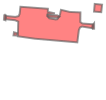

In [213]:
geometry.MultiPolygon(poligono)

In [159]:
import open3d as o3d

In [160]:
bd[['X', 'Y', 'Z']].to_numpy()

array([[96.34, 23.34, 25.91],
       [36.25, 84.97, 27.58],
       [98.55, 77.56, 24.56],
       ...,
       [73.31, 69.95, 27.01],
       [73.28, 70.49, 27.34],
       [73.27, 70.95, 27.38]])

In [161]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(bd[['X', 'Y', 'Z']].to_numpy())

In [162]:
o3d.visualization.draw_geometries([pcd])

In [86]:
diameter = np.linalg.norm(np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))
o3d.visualization.draw_geometries([pcd])

In [87]:
diameter

207.52384947289522

In [88]:

print("Define parameters used for hidden_point_removal")
camera = [0, 0, diameter]
radius = diameter * 1000

print("Get all points that are visible from given view point")
_, pt_map = pcd.hidden_point_removal(camera, radius)

print("Visualize result")
pcd = pcd.select_by_index(pt_map)
o3d.visualization.draw_geometries([pcd])



Define parameters used for hidden_point_removal
Get all points that are visible from given view point
Visualize result
